In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Reading data and creating the ratings matrix
df = pd.read_csv('ratings.csv')

In [3]:
# Filter sparse movies
min_movie_ratings = 10
filter_movies = (df['movieId'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 10
filter_users = (df['userId'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

df = df[(df['movieId'].isin(filter_movies)) & (df['userId'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings

In [4]:
# Shuffle DataFrame
df = df.drop('timestamp', axis=1).sample(frac=1).reset_index(drop=True)
df.head()

,userId,movieId,rating
0,191,162,5.0
1,195,908,5.0
2,288,33493,4.5
3,21,4545,4.0
4,410,2987,4.0


In [5]:
from sklearn.model_selection import train_test_split
df_train , df_test = train_test_split(df, test_size = 0.2)
ratings = pd.pivot_table(df_train, index = 'userId', columns = 'movieId', values = 'rating')
ratings[ratings.isnull()] = -1
ratings=torch.FloatTensor(ratings.values)
non_zero_mask = (ratings != -1).type(torch.FloatTensor)
if(min(torch.sum(non_zero_mask,1))==0):
    print('Do another split')
else:
    print(f"Min no of rating by a user in train set: {min(torch.sum(non_zero_mask,1))}")      

Min no of rating by a user in train set: 7.0


In [6]:
ratings = pd.pivot_table(df_train, index = 'userId', columns = 'movieId', values = 'rating')

#Scaling
min_rating, max_rating = df['rating'].min(), df['rating'].max()
ratings = (ratings - min_rating) / (max_rating - min_rating)

ratings[ratings.isnull()] = -1
ratings = torch.FloatTensor(ratings.values)
ratings = ratings

ratings_original = pd.pivot_table(df_train, index = 'userId', columns = 'movieId', values = 'rating')
ratings_original[ratings_original.isnull()] = -1
ratings_original = torch.FloatTensor(ratings_original.values)
ratings_original = ratings_original


rate2 = pd.pivot_table(df, index = 'userId', columns = 'movieId', values = 'rating')
rate2 = torch.FloatTensor(rate2.values)
rate2 = rate2

rate = pd.pivot_table(df_train, index = 'userId', columns = 'movieId', values = 'rating')
rate[rate.isnull()] = -1
rate[rate >= 0] = np.nan
rate = rate + 1
rate = torch.FloatTensor(rate.values)
rate = rate

test = rate2 - rate
test[torch.isnan(test)] = -1

n_users, n_movies = ratings.shape

### Biased PMF

In [7]:
#Instead of returning the prediction, this returns the loss directly in the forward prop
class BiasedPMFLoss(torch.nn.Module):
    def __init__(self, lam_u=0.3, lam_v=0.3):
        super().__init__()
        self.lam_u = lam_u
        self.lam_v = lam_v
    
    def forward(self, matrix, u_features, v_features, u_bias, v_bias):
        n_users,n_movies=matrix.shape
        non_zero_mask = (matrix != -1).type(torch.FloatTensor)
        bias=u_bias.repeat(1,n_movies)+v_bias.repeat(n_users,1)
        predicted = torch.sigmoid(bias+torch.mm(u_features, v_features.t()))
        
        diff = ((matrix - predicted)**2)
        prediction_error = torch.sum(diff*non_zero_mask)

        u_regularization = self.lam_u * (torch.sum(u_features.norm(dim=1)**2)+u_bias.norm()**2)
        v_regularization = self.lam_v * (torch.sum(v_features.norm(dim=1)**2)+v_bias.norm()**2)
        
        return prediction_error + u_regularization + v_regularization

In [8]:
non_zero_mask = (ratings != -1).type(torch.FloatTensor)
non_zero_mask_test = (test != -1).type(torch.FloatTensor)
D_list = [5,25,50]
results = pd.DataFrame()

In [9]:
for D in D_list:
    latent_vectors, lam_u, lam_v = D, 0.42, 0.42
    user_features = torch.randn(n_users, latent_vectors, requires_grad=True)
    user_features.data.mul_(0.01)
    movie_features = torch.randn(n_movies, latent_vectors, requires_grad=True)
    movie_features.data.mul_(0.01)
    user_bias = torch.randn(n_users, 1, requires_grad=True)
    user_bias.data.mul_(0.01)
    movie_bias = torch.randn(1,n_movies, requires_grad=True)
    movie_bias.data.mul_(0.01)

    PMF_model = BiasedPMFLoss(lam_u, lam_v)
    optimizer = torch.optim.Adam([user_features, movie_features, user_bias, movie_bias], lr=0.01)

    rmse_train=[]
    rmse_test=[]
    for step, epoch in enumerate(range(2000)):
        optimizer.zero_grad()
        loss = PMF_model(ratings, user_features, movie_features, user_bias, movie_bias)
        loss.backward()
        optimizer.step()

        bias=user_bias.repeat(1,n_movies)+movie_bias.repeat(n_users,1)
        predicted = torch.sigmoid(bias+torch.mm(user_features, movie_features.t()))
        predicted = (predicted*(max_rating - min_rating) + min_rating)
        rmse_train.append((torch.sqrt(torch.sum(((predicted - ratings_original) ** 2) * non_zero_mask)/len(df_train))).item())
        rmse_test.append((torch.sqrt(torch.sum(((predicted - test) ** 2) * non_zero_mask_test)/len(df_test))).item())

        if step % 500 == 0:
            print(f"D={D}, Step {step}, {loss:.3f}")
            
    results[str(D) + '_train'] = rmse_train
    results[str(D) + '_test'] = rmse_test

D=5, Step 0, 5436.993
D=5, Step 500, 2105.162
D=5, Step 1000, 2101.455
D=5, Step 1500, 2100.500
D=25, Step 0, 5439.006
D=25, Step 500, 1919.710
D=25, Step 1000, 1917.673
D=25, Step 1500, 1917.319
D=50, Step 0, 5440.474
D=50, Step 500, 1891.661
D=50, Step 1000, 1891.215
D=50, Step 1500, 1891.171


Text(0.5, 0.98, 'Biased PMF')

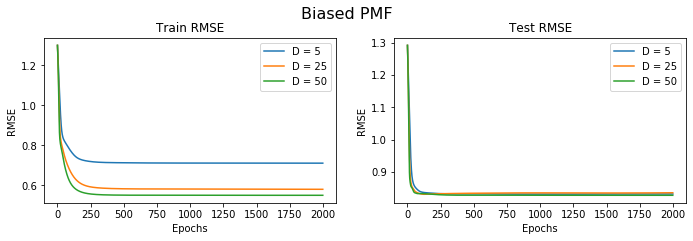

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.plot(results.iloc[:,0], label='D = 5')
ax1.plot(results.iloc[:,2], label='D = 25')
ax1.plot(results.iloc[:,4], label='D = 50')
ax1.set_title('Train RMSE')
ax1.set(xlabel='Epochs', ylabel='RMSE')
ax1.legend()
ax2.plot(results.iloc[:,1], label='D = 5')
ax2.plot(results.iloc[:,3], label='D = 25')
ax2.plot(results.iloc[:,5], label='D = 50')

ax2.set_title('Test RMSE')
ax2.set(xlabel='Epochs', ylabel='RMSE')
ax2.legend()

fig.tight_layout(pad=2.0)
fig.suptitle('Biased PMF', fontsize=16)

In [11]:
#Training error
print("Training Error for Biased PMF")
for i in range(len(D_list)):
    print(f"D={D_list[i]}: {results.iloc[step,i*2]}")
    
print("\n")

#Testing error
print("Testing Error for Biased PMF")
for i in range(len(D_list)):
    print(f"D={D_list[i]}: {results.iloc[step,i*2+1]}")

Training Error for Biased PMF
D=5: 0.7109102606773376
D=25: 0.5802985429763794
D=50: 0.5503436326980591


Testing Error for Biased PMF
D=5: 0.8317464590072632
D=25: 0.8355910181999207
D=50: 0.8277145028114319


### Constrained PMF

In [12]:
#Instead of returning the prediction, this returns the loss directly in the forward prop
class ConstrainedPMFLoss(torch.nn.Module):
    def __init__(self, lam_y=0.4, lam_w=0.4, lam_v=0.3):
        super().__init__()
        self.lam_y = lam_y
        self.lam_w = lam_w
        self.lam_v = lam_v
    
    def forward(self, matrix, Y, W, v_features):
        n_users,n_movies=matrix.shape
        non_zero_mask = (matrix != -1).type(torch.FloatTensor)
        #u_features= (Y+torch.mm(non_zero_mask, W)/torch.sum(non_zero_mask,1).view(n_users,1).repeat(1,latent_vectors))
        predicted = torch.sigmoid(torch.mm((Y+torch.mm(non_zero_mask, W)/torch.sum(non_zero_mask,1).view(n_users,1)), v_features.t()))
        
        diff = ((matrix - predicted)**2)
        prediction_error = torch.sum(diff*non_zero_mask)

        y_regularization = self.lam_y * torch.sum(Y.norm(dim=1)**2)
        w_regularization = self.lam_w * torch.sum(W.norm(dim=1)**2)
        v_regularization = self.lam_v * torch.sum(v_features.norm(dim=1)**2)
        
        return prediction_error + y_regularization + w_regularization + v_regularization

In [13]:
non_zero_mask = (ratings != -1).type(torch.FloatTensor)
non_zero_mask_test = (test != -1).type(torch.FloatTensor)
D_list = [5,25,50]
results = pd.DataFrame()

In [14]:
for D in D_list: 
    latent_vectors, lam_y, lam_w, lam_v = D, 0.5, 0.5, 0.5
    Y = torch.randn(n_users, latent_vectors, requires_grad=True)
    Y.data.mul_(0.01)
    W = torch.randn(n_movies, latent_vectors, requires_grad=True)
    W.data.mul_(0.01)
    movie_features = torch.randn(n_movies, latent_vectors, requires_grad=True)
    movie_features.data.mul_(0.01)

    PMF_model = ConstrainedPMFLoss(lam_y, lam_w, lam_v)
    optimizer = torch.optim.Adam([Y, W, movie_features], lr=0.01)

    rmse_train=[]
    rmse_test=[]

    for step, epoch in enumerate(range(2000)):
        optimizer.zero_grad()
        loss = PMF_model(ratings, Y, W, movie_features)
        loss.backward()
        optimizer.step()

        predicted = (torch.sigmoid(torch.mm((Y+torch.mm(non_zero_mask, W)/torch.sum(non_zero_mask,1).view(n_users,1)), movie_features.t())))
        predicted = (predicted*(max_rating - min_rating) + min_rating)
        rmse_train.append((torch.sqrt(torch.sum(((predicted - ratings_original) ** 2) * non_zero_mask)/len(df_train))).item())
        rmse_test.append((torch.sqrt(torch.sum(((predicted - test) ** 2) * non_zero_mask_test)/len(df_test))).item())

        if step % 500 == 0:
            print(f"D={D}, Step {step}, {loss:.3f}")
            
    results[str(D) + '_train'] = rmse_train
    results[str(D) + '_test'] = rmse_test

D=5, Step 0, 5433.033
D=5, Step 500, 2645.154
D=5, Step 1000, 2642.446
D=5, Step 1500, 2642.314
D=25, Step 0, 5437.904
D=25, Step 500, 2489.269
D=25, Step 1000, 2486.644
D=25, Step 1500, 2486.279
D=50, Step 0, 5443.877
D=50, Step 500, 2470.431
D=50, Step 1000, 2470.045
D=50, Step 1500, 2470.039


Text(0.5, 0.98, 'Constrained PMF')

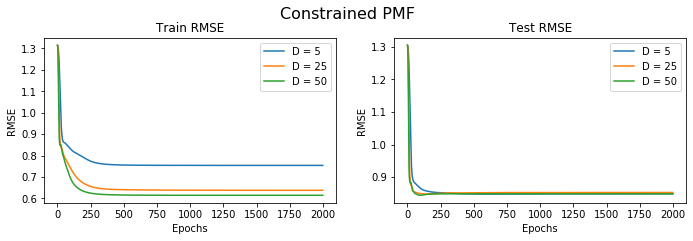

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.plot(results.iloc[:,0], label='D = 5')
ax1.plot(results.iloc[:,2], label='D = 25')
ax1.plot(results.iloc[:,4], label='D = 50')
ax1.set_title('Train RMSE')
ax1.set(xlabel='Epochs', ylabel='RMSE')
ax1.legend()
ax2.plot(results.iloc[:,1], label='D = 5')
ax2.plot(results.iloc[:,3], label='D = 25')
ax2.plot(results.iloc[:,5], label='D = 50')

ax2.set_title('Test RMSE')
ax2.set(xlabel='Epochs', ylabel='RMSE')
ax2.legend()

fig.tight_layout(pad=2.0)
fig.suptitle('Constrained PMF', fontsize=16)

In [16]:
#Training error
print("Training Error for Constrained PMF")
for i in range(len(D_list)):
    print(f"D={D_list[i]}: {results.iloc[step,i*2]}")
    
print("\n")

#Testing error
print("Testing Error for Constrained PMF")
for i in range(len(D_list)):
    print(f"D={D_list[i]}: {results.iloc[step,i*2+1]}")

Training Error for Constrained PMF
D=5: 0.7538262605667114
D=25: 0.6377951502799988
D=50: 0.6145027279853821


Testing Error for Constrained PMF
D=5: 0.8486921191215515
D=25: 0.8526660203933716
D=50: 0.8485327959060669


### Deep PMF

In [17]:
import torch.nn.functional as F

In [18]:
#Instead of returning the prediction, this returns the loss directly in the forward prop
class BiasedDeepPMFLoss(torch.nn.Module):
    def __init__(self, lam_u=0.3, lam_v=0.3, lam_d=0.5):
        super().__init__()
        self.lam_u = lam_u
        self.lam_v = lam_v
        self.lam_d = lam_d
    
    def forward(self, matrix, u_features, v_features, u_bias, v_bias, dense1):
        non_zero_mask = (matrix != -1).type(torch.FloatTensor)
        output1=F.relu(torch.mm(u_features, v_features.t()))
        bias=u_bias.repeat(1,n_movies)+v_bias.repeat(n_users,1)
        predicted = torch.sigmoid(bias+torch.mm(output1, dense1))
        
        diff = ((matrix - predicted)**2)
        prediction_error = torch.sum(diff*non_zero_mask)

        u_regularization = self.lam_u * (torch.sum(u_features.norm(dim=1)**2) + u_bias.norm()**2)
        v_regularization = self.lam_v * (torch.sum(v_features.norm(dim=1)**2) + v_bias.norm()**2)
        d_regularization = self.lam_d * (torch.sum(dense1.norm(dim=1)**2))
        
        return prediction_error + u_regularization + v_regularization + d_regularization

In [19]:
non_zero_mask = (ratings != -1).type(torch.FloatTensor)
non_zero_mask_test = (test != -1).type(torch.FloatTensor)
D_list = [5,25,50]
results = pd.DataFrame()
# the regularization parameters might have to be tuned separately for each D value to achieve the best performance

In [20]:
for D in D_list:     
    latent_vectors, lam_u, lam_v, lam_d = D, 0.3, 0.3, 40
    user_features = torch.randn(n_users, latent_vectors, requires_grad=True)
    user_features.data.mul_(0.01)
    movie_features = torch.randn(n_movies, latent_vectors, requires_grad=True)
    movie_features.data.mul_(0.01)
    user_bias = torch.randn(n_users, 1, requires_grad=True)
    user_bias.data.mul_(0.01)
    movie_bias = torch.randn(1,n_movies, requires_grad=True)
    movie_bias.data.mul_(0.01)
    dense1=torch.randn(n_movies, n_movies, requires_grad=True)
    #dense1.data.mul_(0.01)

    PMF_model = BiasedDeepPMFLoss(lam_u, lam_v, lam_d)
    optimizer = torch.optim.Adam([user_features, movie_features, user_bias, movie_bias, dense1], lr=0.01)

    rmse_train=[]
    rmse_test=[]

    for step, epoch in enumerate(range(2000)):
        optimizer.zero_grad()
        loss = PMF_model(ratings, user_features, movie_features, user_bias, movie_bias, dense1)
        loss.backward()
        optimizer.step()

        output1=F.relu(torch.mm(user_features, movie_features.t()))
        bias=user_bias.repeat(1,n_movies)+movie_bias.repeat(n_users,1)
        predicted = torch.sigmoid(bias+torch.mm(output1, dense1))
        predicted = (predicted*(max_rating - min_rating) + min_rating)
        rmse_train.append((torch.sqrt(torch.sum(((predicted - ratings_original) ** 2) * non_zero_mask)/len(df_train))).item())
        rmse_test.append((torch.sqrt(torch.sum(((predicted - test) ** 2) * non_zero_mask_test)/len(df_test))).item())

        if step % 500 == 0:
            print(f"D={D}, Step {step}, {loss:.3f}")
            
    results[str(D) + '_train'] = rmse_train
    results[str(D) + '_test'] = rmse_test

D=5, Step 0, 179854880.000
D=5, Step 500, 84818.750
D=5, Step 1000, 2253.075
D=5, Step 1500, 2197.029
D=25, Step 0, 179813408.000
D=25, Step 500, 85787.695
D=25, Step 1000, 2261.321
D=25, Step 1500, 2192.985
D=50, Step 0, 180057776.000
D=50, Step 500, 84146.289
D=50, Step 1000, 2252.586
D=50, Step 1500, 2193.339


Text(0.5, 0.98, 'Deep PMF')

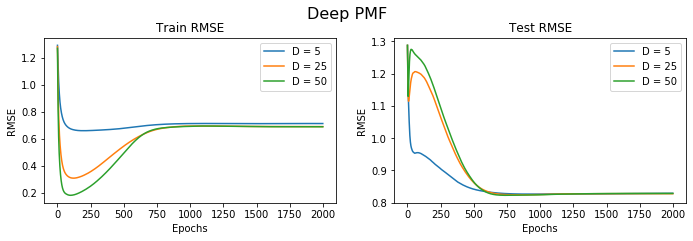

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.plot(results.iloc[:,0], label='D = 5')
ax1.plot(results.iloc[:,2], label='D = 25')
ax1.plot(results.iloc[:,4], label='D = 50')
ax1.set_title('Train RMSE')
ax1.set(xlabel='Epochs', ylabel='RMSE')
ax1.legend()
ax2.plot(results.iloc[:,1], label='D = 5')
ax2.plot(results.iloc[:,3], label='D = 25')
ax2.plot(results.iloc[:,5], label='D = 50')

ax2.set_title('Test RMSE')
ax2.set(xlabel='Epochs', ylabel='RMSE')
ax2.legend()

fig.tight_layout(pad=2.0)
fig.suptitle('Deep PMF', fontsize=16)

In [22]:
#Training error
print("Training Error for Deep PMF")
for i in range(len(D_list)):
    print(f"D={D_list[i]}: {results.iloc[step,i*2]}")
    
print("\n")

#Testing error
print("Testing Error for Deep PMF")
for i in range(len(D_list)):
    print(f"D={D_list[i]}: {results.iloc[step,i*2+1]}")

Training Error for Deep PMF
D=5: 0.7137967944145203
D=25: 0.6911012530326843
D=50: 0.6898464560508728


Testing Error for Deep PMF
D=5: 0.829240620136261
D=25: 0.8280016183853149
D=50: 0.8287838697433472
